# Chunk Size vs. Execution Time

## Introduction
This experiment focuses on exploring the relationship between chunk size and the execution time of distributed computations in Dask.
In distributed systems like Dask, breaking large datasets into smaller chunks allows parallel computation across multiple workers.
However, determining the optimal chunk size can be a challenging task, as it directly affects both performance and resource utilization.

The goal of this experiment is to identify the chunk size that optimally balances task scheduling overhead and computation time to maximize performance.
By testing various chunk sizes, we aim to uncover patterns and insights that can guide best practices in chunking strategies for distributed computing.

## Problem Statement

Choosing the correct chunk size in distributed systems is crucial.
Too small a chunk size can result in excessive overhead from task scheduling and network communication, while too large a chunk size may overwhelm individual workers’ memory and processing capabilities.
This experiment seeks to determine the chunk size that provides the best performance by minimizing execution time while efficiently utilizing computational resources.

The main challenge lies in finding the balance between task scheduling overhead and the computation time of each chunk.
As datasets grow larger, this balance becomes increasingly important in optimizing distributed systems like Dask.

## Key Questions

**1. How does varying the chunk size influence execution time?**
In distributed computations, the chunk size determines how many tasks are created and how much data each worker processes at once.
A larger chunk size reduces the number of tasks but increases the workload per task. Conversely, smaller chunks create more tasks but reduce the per-task workload.
We will explore how changing the chunk size impacts overall execution time, looking for patterns in how the system reacts to different configurations.

**2. What is the relationship between chunk size, task scheduling overhead, and overall computation time?**
Chunking affects not only computation time but also task scheduling.
Task scheduling overhead refers to the time spent assigning tasks to workers, which grows with the number of tasks (i.e., smaller chunk sizes).
The experiment will investigate this relationship, quantifying how much time is spent on task scheduling versus actual computation. Understanding this relationship is critical in finding the right balance between chunk size and system performance.

## Methodology

To explore these questions, this experiment will use the following steps:

1. **Dataset Selection**:
A large seismic dataset will be synthetically generated as the test subject. The dataset will be large enough to stress the system and highlight the performance impact of different chunk sizes.

2. **Algorithm Selection**:
The experiment will utilize a tensorial algorithm commonly used in seismic data processing.
The choice of algorithm is important because different algorithms may have varying sensitivities to chunk size and memory usage, which could affect the execution time and resource utilization.
By focusing on specific algorithms, we will be able to measure chunking performance in a real-world scenario.

4. **Varying Chunk Sizes**:
We will manually set different chunk sizes and observe their impact on execution time. This will include both very small and very large chunk sizes to capture the full spectrum of performance behavior.

5. **Task Scheduling Overhead Analysis**:
For each chunk size, we will measure the task scheduling overhead separately from the computation time. This will help quantify the relationship between task scheduling and execution time.

6. **Performance Tracking**:
Execution time will be tracked and logged for each experiment. In addition, memory usage and CPU utilization will be monitored to ensure that resource constraints (e.g., memory saturation) do not bias the results.

7. **Results Comparison**:
Once the experiments are complete, we will analyze the results to find the optimal chunk size that balances execution time and resource utilization. A comparison will be made across different chunk sizes to identify patterns and trade-offs.

This methodology will provide insights into how chunk sizes affect performance and help identify strategies to optimize chunking for future distributed computations.

## Experiment Execution

Before starting the experiment, we need to set up the environment to ensure all steps run smoothly. It is assumed that you have already installed all the required dependencies from the root requirements.txt file located at `../requirements.txt`.

In [1]:
import sys
import os

def link_libs_to_path():
    libs_path = os.path.abspath('../libs')
    if libs_path not in sys.path:
        sys.path.append(libs_path)
    
    are_libs_in_sys_path = libs_path in sys.path
    print(f"Are libs properly linked to your sys.path? -> {'Yes' if are_libs_in_sys_path else 'No'}")

link_libs_to_path()

Are libs properly linked to your sys.path? -> Yes


### Dataset Selection

In this experiment, we will generate a synthetic seismic cube to serve as our dataset.
Seismic cubes are typically large, multi-dimensional arrays, making them ideal for testing distributed computation and chunking strategies.

To generate the dataset, we will utilize utility libraries that have already been linked to your sys.path during the environment setup.
These libraries provide convenient functions for creating large datasets with configurable shapes, allowing you to adjust the size of the cube according to your machine’s available memory.

You can modify the cube’s shape in the initial parameters of the notebook.
We recommend setting the dimensions of the seismic cube based on the memory capacity of your machine to prevent memory overload and ensure smooth execution of the experiment.
If you are unsure, start with smaller sizes and gradually increase them to explore the impact on execution time and performance.

2024-10-21 21:31:57 - dataset-selection - INFO - Generating seismic data with dimensions: NUM_INLINES=600, NUM_XLINES=600, NUM_SAMPLES=600
2024-10-21 21:31:57 - dataset-selection - INFO - Output will be saved to ./outputs/001-20241021213157
2024-10-21 21:31:57 - generate-seismic-data - INFO - Generating synthetic data for shape (600, 600, 600)
2024-10-21 21:32:30 - dataset-selection - INFO - Seismic data generation completed. Data saved to ./outputs/001-20241021213157/data/600-600-600.segy


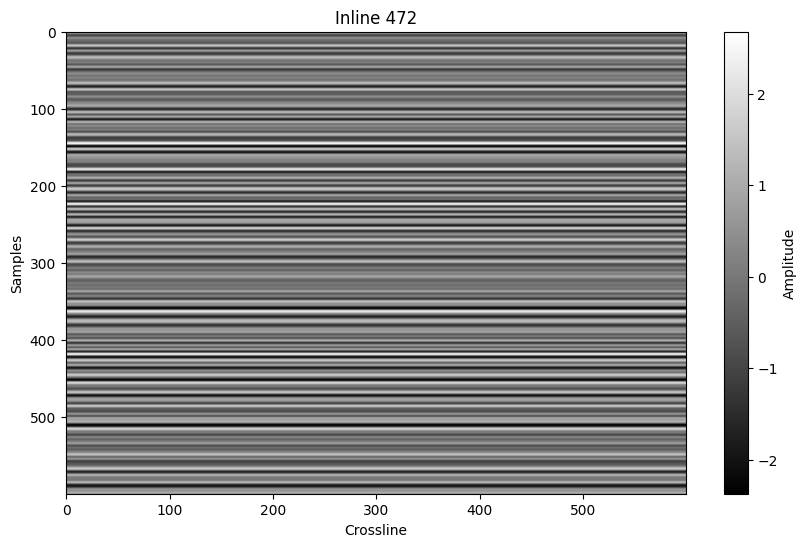

In [2]:
import os

from utils import generate_output_dir_path
from datasets import generate_seismic_data, load_segy, render_random_inline
from loggers import get_named_logger

logger = get_named_logger('dataset-selection')

NUM_INLINES = 600
NUM_XLINES = 600
NUM_SAMPLES = 600

OUTPUT_DIR = generate_output_dir_path('001')
DATA_DIR = os.path.join(OUTPUT_DIR, 'data')

logger.info(
    f"Generating seismic data with dimensions: "
    f"NUM_INLINES={NUM_INLINES}, NUM_XLINES={NUM_XLINES}, NUM_SAMPLES={NUM_SAMPLES}")
logger.info(f"Output will be saved to {OUTPUT_DIR}")

seismic_data_path = generate_seismic_data(
    NUM_INLINES,
    NUM_XLINES,
    NUM_SAMPLES,
    output_dir=DATA_DIR,
)

logger.info(f"Seismic data generation completed. Data saved to {seismic_data_path}")

seismic_data = load_segy(seismic_data_path)
render_random_inline(seismic_data)

### Algorithm Selection

In this experiment, we will test the impact of chunk sizes on the execution of several algorithms, focusing on both seismic-specific and general-purpose computations.
These algorithms will help us understand how chunk size affects different types of computational workloads, from simpler to more complex tasks.
The selected algorithms include:

- **Envelope**:
The envelope algorithm is widely used in seismic processing to extract the instantaneous amplitude of a seismic signal.
It is computationally lightweight and generally does not require significant memory resources.
This makes it an ideal candidate for testing chunk size behavior under less memory-intensive conditions, allowing us to observe how Dask’s chunking strategies perform with lower memory consumption.

- **GST3D (Generalized S-transform in 3D)**:
GST3D is a time-frequency analysis algorithm applied to 3D seismic data.
Unlike the envelope algorithm, GST3D is computationally heavy and memory-intensive.
It requires multiple transformations and matrix operations across the entire seismic cube, which quickly consumes memory, especially as the data size grows.
This algorithm will help us stress-test chunking performance under memory-constrained conditions, providing valuable insights into how Dask handles chunking for complex seismic computations.

- **3D Gaussian Filtering**:
To include a non-seismic algorithm that can still process 3D data like a seismic cube, we suggest 3D Gaussian Filtering.
This is a standard algorithm used in image and signal processing for smoothing data and reducing noise.
The algorithm performs convolution over the 3D array (the seismic cube), making it computationally relevant to chunking strategies in a distributed setting.
It is not as memory-intensive as GST3D but still requires substantial computation, making it an excellent candidate for exploring how chunk size impacts non-seismic algorithms.

By testing these three algorithms: one lightweight (Envelope), one heavy (GST3D), and one general-purpose (3D Gaussian Filtering), we can evaluate how chunk size affects performance in both simple and complex computational contexts.
The goal is to find chunking strategies that strike the best balance between execution time and memory usage, based on the complexity of the algorithm and the data size.

In [3]:
from operators import envelope_from_segy, gradient_structure_tensor_from_segy, gaussian_filter_from_segy
from loggers import get_named_logger

logger = get_named_logger('algorithm-selection')

apply_envelope = envelope_from_segy
apply_gst3d = gradient_structure_tensor_from_segy
apply_gaussian_filter = gaussian_filter_from_segy

logger.info(f'Envelope using {apply_envelope}')
logger.info(f'GST3D using {apply_gst3d}')
logger.info(f'3D Gaussian Filter using {apply_gaussian_filter}')

ModuleNotFoundError: No module named 'dask'

### Collecting Data

Now that the seismic data has been generated and the algorithms have been selected, the next step involves preparing the data for the experiment.
Here’s how we’ll proceed with collecting and organizing the necessary data for analysis:

1. **Chunk Size Configuration**:
We will begin by manually configuring different chunk sizes.
These chunk sizes will range from very small to large, allowing us to observe the full impact on execution time and resource usage.
Each chunk size will be applied to the same synthetic seismic dataset to ensure consistent comparison.

2. **Running the Algorithms**:
For each configured chunk size, the selected algorithms (Envelope, GST3D, and 3D Gaussian Filtering) will be applied to the seismic dataset.
Each algorithm will be executed across multiple chunk size configurations, and the performance metrics will be recorded.

3. **Task Scheduling and Execution Time Data**:
During the execution of each algorithm, we will collect detailed performance data:
    - Execution Time: The total time taken to process the seismic data for each algorithm using the specified chunk size. This includes both computation time and task scheduling time.
    - Task Scheduling Overhead: Dask’s task scheduling overhead will be monitored separately to understand the impact of chunk size on the overhead. This data will help isolate the time spent on scheduling tasks versus the time spent on computation.
    - Memory Usage and CPU Utilization: Memory consumption and CPU usage will be tracked for each run. These metrics are critical to understanding how chunk size affects system resource allocation and will help identify any memory or CPU bottlenecks.

4. **Logging and Storing the Results**:
The collected data will be logged for each chunk size configuration.
This will include the execution time, task scheduling overhead, memory usage, and CPU utilization for all algorithms. The results will be stored in a structured format for later analysis.

By collecting this data across a range of chunk sizes, we will be able to visualize the relationship between chunk size, task scheduling overhead, and execution time.
This will allow us to identify the optimal chunk size that balances performance and resource usage, ultimately guiding best practices in distributed chunking strategies for future computations.